# Jax + Flax Binary Image Classifier 

Minimum viable example of *training* (testing coming soon) a simple binary image classifier using jax + flax. 

## 1. Import data 

In [6]:
import pickle
in_file = open('norm_fmnist.pkl', 'rb')
d_set = pickle.load(in_file)

Data is a list of the form `[(x,y), (x,y),..., (x,y)]` where each `x` is normalized jnp float array and each `y` is a single float representing the label. 

## 1. Build and initialize the model 

In [10]:
import jax
import jax.numpy as jnp                # JAX NumPy
from flax import linen as nn           # The Linen API
import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers

In [11]:
class MLP(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = jnp.ravel(x)  # flatten 
    x = nn.Dense(features=784)(x)
    x = nn.Dense(features=2)(x)  # 2 because we are using softmax cross entropy 
    return nn.softmax(x) 

In [13]:
mlp_model = MLP()
sample_batch = jnp.ones((1, 28,28))
parameters = mlp_model.init(jax.random.PRNGKey(1), sample_batch)  # model param that we'll train 

In jax + flax, the model is separate from the params. The params are what we change during training. 

## 2. Set up training 

- Loss
- Accuracy metric 
- Optimizer 


In [15]:
def binary_loss(logits, labels):
    """
    input form: 
        - logits: shape is (2,) e.g., DeviceArray([0.36671272, 0.63328725], dtype=float32) 
        - labels: int/float e.g., 1.0 
    """
    # binary cross entropy loss 
    # both logits and labels should be shape [batch, num_classes] 
    # so we will one hot encode the label given! 
    one_hot_labels = jax.nn.one_hot([labels], num_classes=2)
    return optax.softmax_cross_entropy(logits=logits.reshape(1,2), labels=one_hot_labels)

In [17]:
def compute_accuracy(logits, labels):
    """
    input form: 
        - logits: shape is (2,) e.g., DeviceArray([0.36671272, 0.63328725], dtype=float32) 
        - labels: int/float e.g., 1.0 
    """
    if jnp.argmax(logits) == labels:
        return 1
    else:
        return 0 

Set up optimizer 

In [18]:
# Same as version above but with model.apply().
@jax.jit  # wrap in jit for speed-up! 
def forward_loss(params, x, y):
    pred_logits = mlp_model.apply(params, x)
    return binary_loss(pred_logits, y).mean()  # use mean to extract value 

In [20]:
LR = 0.001
tx = optax.sgd(learning_rate=LR)  # tx is the optimizer 
opt_state = tx.init(parameters)  # tx needs a state that we init here 
# wrap loss func in function that will simultaneously calculate value and gradient
loss_grad_fn = jax.value_and_grad(forward_loss)  

## 3. Training loop 

Update model params... 

In [21]:
NUM_EPOCHS = 20
losses = []
accuracies = []
for i in range(NUM_EPOCHS):
    batch_loss = 0
    batch_num_correct = 0  # for accuracy calculation  
    
    # loop over entire dataset 
    for sample in d_set:
        x = sample[0]
        y = sample[1]
        
        # compute accuracy 
        sample_acc = compute_accuracy(mlp_model.apply(parameters, x), y) 
        if sample_acc > 0:
            batch_num_correct += 1
        
        # update params  (note: eventually wrap this in function so that you can jit it) 
        loss_val, grads = loss_grad_fn(parameters, x, y)
        batch_loss += loss_val  # record sample loss 
        updates, opt_state = tx.update(grads, opt_state)
        parameters =  optax.apply_updates(parameters, updates)  # updating of params
        
    
    # log epoch metrics 
    epoch_loss = batch_loss/len(d_set)
    epoch_acc = batch_num_correct/len(d_set)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc) 
    
    # prints 
    print('Loss step {}: '.format(i + 1), epoch_loss)
    print('Accuracy step {}: '.format(i + 1), epoch_acc)

Loss step 1:  0.5804289
Accuracy step 1:  0.8793103448275862
Loss step 2:  0.4941133
Accuracy step 2:  0.9827586206896551
Loss step 3:  0.4497453
Accuracy step 3:  1.0
Loss step 4:  0.4228556
Accuracy step 4:  1.0
Loss step 5:  0.4050223
Accuracy step 5:  1.0
Loss step 6:  0.39231786
Accuracy step 6:  1.0
Loss step 7:  0.38278383
Accuracy step 7:  1.0
Loss step 8:  0.37534776
Accuracy step 8:  1.0
Loss step 9:  0.36937493
Accuracy step 9:  1.0
Loss step 10:  0.36446473
Accuracy step 10:  1.0
Loss step 11:  0.36035222
Accuracy step 11:  1.0
Loss step 12:  0.35685465
Accuracy step 12:  1.0
Loss step 13:  0.35384172
Accuracy step 13:  1.0
Loss step 14:  0.35121778
Accuracy step 14:  1.0
Loss step 15:  0.3489112
Accuracy step 15:  1.0
Loss step 16:  0.346867
Accuracy step 16:  1.0
Loss step 17:  0.34504232
Accuracy step 17:  1.0
Loss step 18:  0.3434034
Accuracy step 18:  1.0
Loss step 19:  0.34192285
Accuracy step 19:  1.0
Loss step 20:  0.34057885
Accuracy step 20:  1.0


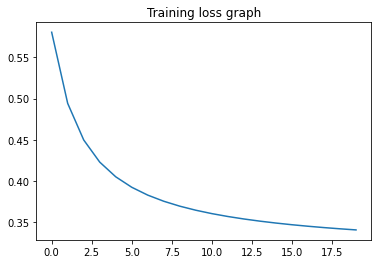

In [28]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Training loss graph")
plt.show()

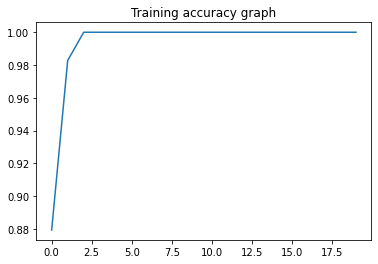

In [29]:
plt.plot(accuracies)
plt.title("Training accuracy graph")
plt.show()

Evaluation on test set coming soon... 